In [1]:
import numpy as np
from time import strftime

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def setup_model(exp_params):
    model = dict()
    model['tm'] = ec2b.TemporalModel(tsample=exp_params['tsample'])
    
    # Create an Argus I array with old labeling
    argus = e2cm.ArgusI(x_center=-1143.051, y_center=-271.21, h=100, rot=39.4*np.pi/180)
    # TODO:
    # - add ElectrodeArray.set_custom_names()
    # - get rid of ElectrodeArray.names, since it is redundant
    # - have get_index() iterate over Electrode.name entries
    names = ['L6','L2','M8','M4','L5','L1','M7','M3','L8','L4','M6','M2','L7','L3','M5','M1']
    argus.names = np.array([names], dtype=np.str).flatten()
    for i, (a, n) in enumerate(zip(argus, names)):
        argus[i].name = n
    model['implant'] = argus
    
    # Create a retina that fits the implant
    round_to = 500  # round to nearest (microns)
    cspread = 500  # expected current spread (microns)
    xs = [a.x_center for a in argus]
    ys = [a.y_center for a in argus]
    xlo = np.floor((np.min(xs) - cspread) / round_to) * round_to
    xhi = np.ceil((np.max(xs) + cspread) / round_to) * round_to
    ylo = np.floor((np.min(ys) - cspread) / round_to) * round_to
    yhi = np.ceil((np.max(ys) + cspread) / round_to) * round_to
    model['retina'] = e2cm.Retina(sampling=exp_params['r_sampling'],
                                  xlo=xlo, xhi=xhi, ylo=ylo, yhi=yhi,
                                  axon_lambda=exp_params['axon_lambda'],
                                  rot=exp_params['r_rot_deg']*np.pi/180,
                                  loadpath=exp_params['save_dir'])
    # TODO: loadpath is also a savepath...maybe rename to datapath?
    
    # Plot axon bundles (plot every 5th for the sake of visualization)
    fig, ax = plt.subplots(1)
    ax.set_axis_bgcolor('black')
    ax.plot(model['retina'].jan_x[:, ::5], -model['retina'].jan_y[:, ::5],
            c=(0.5, 1, 0.5))

    # Plot location of implant on top of axon bundles
    for e in model['implant']:
        ax.text(e2cm.micron2deg(e.x_center + 10), -e2cm.micron2deg(e.y_center + 5),
                e.name, color='white', size='x-large')
        ax.plot(e2cm.micron2deg(e.x_center), -e2cm.micron2deg(e.y_center), 'ow',
                markersize=np.sqrt(e.radius))
    ax.set_aspect('equal')
    ax.set_xlim(-15, 15)
    ax.set_xlabel('visual angle (deg)')
    ax.set_ylim(-10, 10)
    ax.set_ylabel('visual angle (deg)')
    ax.set_title('Image flipped (upper retina = upper visual field)')
    fig.savefig(exp_params['save_dir'] + 'implant.eps')
    
    return model

In [3]:
def run_condition(idx_cond, exp_params, model):
    """Run a single condition of the Horsager experiment"""
    
    if idx_cond != 1:
        raise ValueError('Unknown idx_cond ' + str(idx_cond))
    
    name_E1 = exp_params['name_E1']
    name_E2 = exp_params['name_E2']
    assert name_E1 is not None or name_E2 is not None
    
    # Set up currents and delays
    amp_E1 = exp_params['amp_thresh'] + np.array([30, 100, 200])
    amp_E2 = exp_params['amp_thresh'] + np.array([30, 100, 200])
        
    data = dict()
    data['frames'] = []
    data['amp_E1'] = []
    data['amp_E2'] = []
    print ("- Condition %d" % idx_cond)
    for a1 in amp_E1:
        for a2 in amp_E2:
            # generate list of pulse trains
            pt_e1 = get_pulse_train(a1, tsample=exp_params['tsample'])
            pt_e2 = get_pulse_train(a2, tsample=exp_params['tsample'])
            if name_E1 is None:
                pt = {name_E2: pt_e2}
            elif name_E2 is None:
                pt = {name_E1: pt_e1}
            else:
                pt = {name_E1: pt_e1, name_E2: pt_e2}
                
            resp = ec2b.pulse2percept(pt, model['implant'], model['tm'], model['retina'],
                                      use_ecs=exp_params['use_ecs'], tol=exp_params['tol'],
                                      n_jobs=8)

            # Find brightest frame
            brightest = ec2b.get_brightest_frame(resp)

            # Save data
            data['frames'].append(brightest)
            data['amp_E1'].append(a1)
            data['amp_E2'].append(a2)
            
    return data

In [4]:
def run_experiment(exp_params, model):
    exp_params['date'] = strftime("%Y-%m-%d")
    print('Experiment: %s %s, %s' % (exp_params['name'], exp_params['name_E1'], exp_params['name_E2']))
    print('- Start time: %s %s' % (exp_params['date'], strftime("%H:%M:%S")))
    
    datapath = exp_params['save_dir']
    if not datapath.endswith('/'):
        datapath += '/'
    prefix = exp_params['name']
    electrodes = '%s_%s' % (exp_params['name_E1'], exp_params['name_E2'])
    suffix = '%s.npz' % exp_params['date']

    # Check if we ran this experiment already
    import os
    for file in os.listdir(datapath):
        if file.startswith(prefix + '_' + electrodes):
            print('File that starts with %s%s_%s already exists, skip' % (datapath,
                                                                          prefix,
                                                                          electrodes))
            return

    # Generate filename and make sure we can write to it
    # Do this now rather than after hours of number crunching...
    filename = '%s%s_%s_%s' % (datapath, prefix, electrodes, suffix)
    np.savez(filename, data=np.zeros(10))
    os.remove(filename)
    print('- File: %s' % filename)
    exp_params['filename'] = filename

    # Run all 5 conditions
    data = dict()
    for idx_cond in range(1):
        name_cond = 'cond' + str(idx_cond + 1)
        data[name_cond] = run_condition(idx_cond + 1, exp_params, model)

    # Save results to .npz
    np.savez(filename, data=data, exp_params=exp_params, model=model)
    print('- Results saved to %s' % filename)
    print('- End time: %s' % strftime("%Y-%m-%d %H:%M:%S"))

In [5]:
# We could use ec2b.Psycho2Pulsetrain, but we'd like to have the stimulus first, 
# followed by the inter-pulse gap. ec2b.Psycho2Pulsetrain has the inter-pulse
# gap first...
def get_pulse_train(amp, tsample, delay_dur=0):
    freq = 20
    pulse_dur = 0.45/1000
    stim_dur = 0.5
    return e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=stim_dur, delay=delay_dur,
                                  pulse_dur=pulse_dur, interphase_dur=pulse_dur)

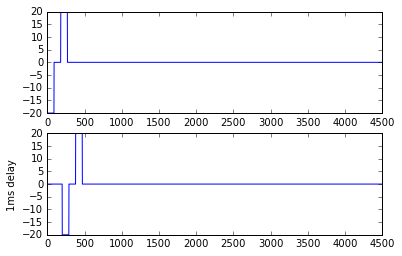

In [6]:
plt.subplot(211)
plt.plot(get_pulse_train(20, 5e-6, 0).data[0:4500])

plt.subplot(212)
plt.plot(get_pulse_train(20, 5e-6, 1/1000).data[0:4500])
plt.ylabel('1ms delay')

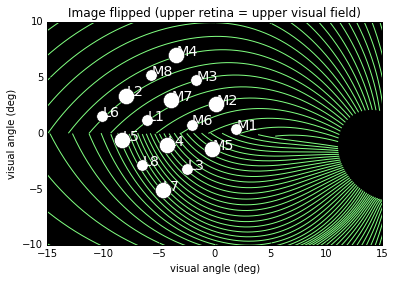

In [7]:
exp_params = dict()

# give the experiment a name
exp_params['name'] = 'TB-20090311'

# sampling step in seconds
exp_params['tsample'] = 0.005 / 1000

# threshold current in micro amps
exp_params['amp_thresh'] = 15

# whether to use effective current map (True) or current map (False)
exp_params['use_ecs'] = True

exp_params['axon_lambda'] = 8
exp_params['r_sampling'] = 50
exp_params['r_rot_deg'] = 0
exp_params['tol'] = 0.5

# where to save the data (relative path)
exp_params['save_dir'] = '/home/mbeyeler/data/shape/lambda%.1f/' % exp_params['axon_lambda']

model = setup_model(exp_params)

In [8]:
# different electrode pairs
name_E1 = ['L1', 'L1', 'L2', 'L2', 'L2', 'M2', 'M3', 'M3', 'M4', 'M4']
name_E2 = [None, 'M2', None, 'M3', 'M4', None, None, 'L2', None, 'L2']

for name1, name2 in zip(name_E1, name_E2):
    exp_params['name_E1'] = name1
    exp_params['name_E2'] = name2
    
    t_exe = %timeit -oq -n1 -r1 run_experiment(exp_params, model)
    print('- Experiment took %.1f s' % t_exe.best)

Experiment: TB-20090311 L1, None
- Start time: 2016-12-10 00:51:05
- File: /home/mbeyeler/data/shape/lambda8.0/TB-20090311_L1_None_2016-12-10.npz
- Condition 1
tol=0.500000, 6193 out of 9191 pixels selected
tol=0.500000, 6193 out of 9191 pixels selected
tol=0.500000, 6193 out of 9191 pixels selected
tol=0.500000, 6193 out of 9191 pixels selected
tol=0.500000, 6193 out of 9191 pixels selected
tol=0.500000, 6193 out of 9191 pixels selected
tol=0.500000, 6193 out of 9191 pixels selected
tol=0.500000, 6193 out of 9191 pixels selected
tol=0.500000, 6193 out of 9191 pixels selected
- Results saved to /home/mbeyeler/data/shape/lambda8.0/TB-20090311_L1_None_2016-12-10.npz
- End time: 2016-12-10 01:18:37
- Experiment took 1651.9 s
Experiment: TB-20090311 L1, M2
- Start time: 2016-12-10 01:18:37
- File: /home/mbeyeler/data/shape/lambda8.0/TB-20090311_L1_M2_2016-12-10.npz
- Condition 1
tol=0.500000, 6193 out of 9191 pixels selected
tol=0.500000, 6193 out of 9191 pixels selected
tol=0.500000, 6193